# Import needed libraries & adjust output settings

In [1]:
#standard need libraries
import pandas as pd
import numpy as np

#libraries to scrape CAVA locations website
import requests
from bs4 import BeautifulSoup as bsoup

#import library for manipulating json files
import json

#library to get coordinates from city name
from opencage.geocoder import OpenCageGeocode

print('\nLibraries imported\n')


Libraries imported



In [2]:
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOption set to display all dataframe rows and columns.\n')


Option set to display all dataframe rows and columns.



#### 

# Make dataframe of location info for CAVA zip codes

In [ ]:
#### Scrape html doc with CAVA location info from website

In [ ]:
response = requests.get('https://cava.com/locations')

#check that get attempt worked by printing a few lines
print(response.text[0:250])

#make a beautiful soup object with parsed html
cav_soup = bsoup(response.text, 'html.parser')

In [ ]:
#### Get all html blocks that have location info for CAVA restaurants across US

In [ ]:
cav_locs_soup = cav_soup.find_all('div', class_ = 'adr copy')

#see how many CAVA locations there are
print('\nNumber of CAVA sites: ', len(cav_locs_soup), '\n', sep = '')

# show structure of info for first listed CAVA location (to know who to extract info)
print(cav_locs_soup[0].prettify())

In [ ]:
#### Extract info for first listed CAVA location to check that it's possible

In [ ]:
#extract info for first listed CAVA location to check that it's possible
locality = cav_locs_soup[0].find('span', class_ = 'locality').text
state = cav_locs_soup[0].find('span', class_ = 'region').text
address = cav_locs_soup[0].find('div', class_ = 'street-address').text
postal_code = cav_locs_soup[0].find('span', class_ = 'postal-code').text

print('\nFirst Location:\n\n',
      locality, ', ', state, '\n',
      address, ', ', postal_code, '\n',
      sep = '')

In [ ]:
#### Get list of needed info for all CAVA locations

In [ ]:
## Initialize a list to store all info in format for conversion to dataframe
cav_info_list = []

## Add info for each CAVA site to list
for cava in cav_locs_soup:    
    
    city = cava.find('span', class_ = 'locality').text
    state = cava.find('span', class_ = 'region').text
    postal_code = cava.find('span', class_ = 'postal-code').text

    cav_info_list.append([postal_code, ', '.join([city , state])])

## Check that list has info for every CAVA: 105 Expected
print('\nExpected number of CAVA locations: 105')
print('Length of loc info list: ', len(cav_info_list), '\n', sep = '')    

print('Sample locations:')
for city in cav_info_list[0:20]:
    print(city)
print('\n')

In [ ]:
#### Convert info list to dataframe and add needed info

In [ ]:
## Convert list to dataframe
cav_loc_info_df = pd.DataFrame(cav_info_list, columns = ['Zip Code', 'City'])
cav_loc_info_df['Latitude'] = ["NA"] * len(cav_loc_info_df)
cav_loc_info_df['Longitude'] = ["NA"] * len(cav_loc_info_df)

## Fix entry errors found in course of development
cav_loc_info_df.loc[47, 'City'] = 'Raleigh, NC'

for i, row in cav_loc_info_df.iterrows():
    if row['City'].split(',')[-1] == ' VA ':
        row['City'] = row['City'].split(',')[0] + ', VA'
        
## Drop duplicate rows (because some zip codes might have more than 1 CAVA)
cav_loc_info_df.drop_duplicates(inplace = True)

print('\nDataframe Shape: \n', cav_loc_info_df.shape, '\n', sep = '')
cav_loc_info_df.sort_values(by = 'Zip Code').head(10)

In [ ]:
## Get coordinates for each row
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

total = len(cav_loc_info_df)
completed = 0

for i, row in cav_loc_info_df.iterrows():
    
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])
    
    location = zip_geocoder.geocode(query = input_address)
    row['Latitude'] = location[0]['geometry']['lat']
    row['Longitude'] = location[0]['geometry']['lng']
    
    completed += 1
    print('Percent completed: {:%}'.format(completed/total), end = '\r')

print('\n\nDataframe Shape: \n', cav_loc_info_df.shape, '\n', sep = '')
cav_loc_info_df.sort_values(by = 'Zip Code').head(10)

In [ ]:
## Add variable that records that each zip code in this dataframe has a CAVA
columns = cav_loc_info_df.columns.tolist()
cav_loc_info_df['Has CAVA?'] = [1] * len(cav_loc_info_df)
cav_loc_info_df = cav_loc_info_df[['Has CAVA?'] + columns]

print('\nDataframe Shape: \n', cav_loc_info_df.shape, '\n', sep = '')
cav_loc_info_df.sort_values(by = 'Zip Code').head(10)

In [ ]:
#### Save dataframe to personal computer for later use (so that entire notebook does not have to be run each time)

In [ ]:
cav_loc_info_df.to_csv('/Users/mitchelllee/cava_loc_info_df')
print('\nDataframe saved.')

#### 

#### 

# Make Dataframe of Location Info for non-CAVA Zip Codes in States with CAVA

In [ ]:
#### Load in dataframe with info for zip codes with CAVAs saved on personal compuer

In [ ]:
## Read in dataset
cav_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_loc_info_df', dtype = {'Zip Code' : str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', cav_loc_info_df.shape, '\n', sep = '')
cav_loc_info_df.sort_values(by = 'Zip Code').head()

In [ ]:
#### Get list of states with CAVAs

In [ ]:
## Get list of cities (including state abbreviations) that have CAVA
cav_cities = set(cav_loc_info_df['City'])
cav_states = []

## For each city, add state abbreviation to list (will remove duplicates with later set function)
for city in cav_cities:
    cav_states.append(city.split(', ')[-1])

## #liminate duplicates and ignore DC because we won't be putting any new CAVAs in DC (because it already has so many)
cav_states = list(set(cav_states) - set(['DC']))
cav_states.sort()
print(cav_states)

In [ ]:
#### Get list of zip codes with CAVA

In [ ]:
## Get list of cities with CAVA locations
cav_postals = set(cav_loc_info_df['Zip Code'])

## Show some of the zip codes to confirm code worked
print(cav_postals)

In [ ]:
#### Make dataframe of postal codes without CAVA (in states with CAVAs)

In [ ]:
## Initialize the overall dataframe
nocav_loc_info_df = pd.DataFrame(columns=['Zip Code', 'City'])

## Create state abbreviation dictionary from internet
states_abbvs_dict = {
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'NC': 'North Carolina',
        'NJ': 'New Jersey',
        'NY': 'New York',
        'PA': 'Pennsylvania',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'VA': 'Virginia'
}

## Define variables to report progress through code
completed = 0
total = len(cav_states)

## For each state, make dataframe of largest non-CAVA zip codes by population
for state in cav_states:
    
    ## Get zip codes in state with biggest populations
    # write state name in format appropriate for url (use dict to get full state name, remove any spaces, then make lowercase)
    state_name_v1 = ''.join(states_abbvs_dict[state].split(' ')).lower() #use states dict to get full state name, remove any spaces, then make lowercase (for use to find url)
    # read in table from the url
    postals = pd.read_html('https://www.{}-demographics.com/zip_codes_by_population'.format(state_name_v1))[0]['Zip Code'][0:30].astype(str).tolist()          
    # remove zip codes that already have CAVA
    nocav_postals = list(set(postals) - set(cav_postals))      
    # make into dataframe
    nocav_postals_df = pd.DataFrame(nocav_postals, columns=['Zip Code']).reset_index().drop('index', axis =1)
    nocav_postals_df['Zip Code'] = nocav_postals_df['Zip Code'].astype(str)

    ## Get city associated with zip code in current state
    state_name_v2 = '%20'.join(states_abbvs_dict[state].split(' '))
    cits_df = pd.read_html('https://www.zipcodestogo.com/{}/'.format(state_name_v2))[1].iloc[2:,0:2].reset_index().drop('index', axis = 1)
    cits_df.columns = ['Zip Code', 'City']
    cits_df['Zip Code'] = cits_df['Zip Code'].astype(str)
    cits_df['City'] = cits_df['City'] + ', ' + state
    
    ## Merge 'no_cav_postals_df' and 'cits_df'
    nocav_postals_df = nocav_postals_df.merge(cits_df, on = 'Zip Code')
    
    ## Add state-specific dataframe to overall dataframe with append method
    nocav_loc_info_df = nocav_loc_info_df.append(nocav_postals_df)
    
    completed += 1
    print('Percent completed: {:%}'.format(completed/total), end = '\r')


print('\nDataframe shape: ', nocav_loc_info_df.shape, '\n', sep = '')
nocav_loc_info_df.sort_values(by = 'Zip Code').head()

In [ ]:
#### Fill in missing components of dataframe

In [ ]:
## Reset 'nocav_loc_df' index and drop old indexing from sub dataframes
nocav_loc_info_df = nocav_loc_info_df.reset_index().drop('index', axis = 1)
nocav_loc_info_df['Latitude'] = ['NA'] * len(nocav_loc_info_df)
nocav_loc_info_df['Longitude'] = ['NA'] * len(nocav_loc_info_df)
nocav_loc_info_df['Has CAVA?'] = 0 * len(nocav_loc_info_df)

## Assign 'Has CAVA' variable to 'No'
nocav_loc_info_df['Has CAVA?'] = [0] * len(nocav_loc_info_df)

## Get coordinates for each zip code
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

total_items = len(nocav_loc_info_df)
completed_items = 0

for i, row in nocav_loc_info_df.iterrows():
    
    # format address of row appropriately
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])

    # make query
    location = zip_geocoder.geocode(query = input_address)
    nocav_loc_info_df.loc[i, 'Latitude'] = location[0]['geometry']['lat']
    nocav_loc_info_df.loc[i, 'Longitude'] = location[0]['geometry']['lng']
    
    completed_items += 1
    print('Percent remaining: {:%}'.format(completed_items/total_items), end = '\r')


nocav_loc_info_df = nocav_loc_info_df[['Has CAVA?','Zip Code','City','Latitude','Longitude']]    
    
print('\nDataframe shape: ', nocav_loc_info_df.shape, '\n')
nocav_loc_info_df.sort_values(by = 'Zip Code').head()

In [ ]:
#### Save dataframe to personal computer for later use (so that entire notebook does not have to be run each time)

In [ ]:
nocav_loc_info_df.to_csv('/Users/mitchelllee/nocava_loc_info_df')
print('\nDataframe saved.')

#### 

#### 

# Combine cAVA and non-CAVA info dataframes

In [ ]:
#### Load 'cava_loc_info_df'

In [ ]:
cava_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.sort_values(by = 'Zip Code').head()

In [ ]:
#### Load 'nocava_loc_info_df'

In [ ]:
nocava_loc_info_df = pd.read_csv('/Users/mitchelllee/nocava_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', nocava_loc_info_df.shape, '\n', sep = '')
nocava_loc_info_df.sort_values(by = 'Zip Code').head()

In [ ]:
#### Combine 'cav_loc_info_df' & 'nocav_loc_info_df' into one dataframe

In [ ]:
## Use append method to combine
combined_loc_info_df = cav_loc_info_df.append(nocav_loc_info_df).reset_index().drop(['index'], axis = 1)
combined_loc_info_df.drop_duplicates(inplace = True)

## Find expected dataframe size
print('\nExpected dataframe shape: ({}, {})'.format(len(cav_loc_info_df) + len(nocav_loc_info_df), len(cav_loc_info_df.columns)))

print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.sort_values(by = 'Zip Code').head()

In [ ]:
#### Write dataset to csv file stored on computer for permanent access of later stages

In [ ]:
combined_loc_info_df.to_csv('/Users/mitchelllee/cava_combo_loc_info_df')
print('\nDataframe saved.')

#### 

# Get dataframe of venues around each zip code in 'combined_loc_info_df'

In [ ]:
#### Read in location info dataset from personal computer

In [7]:
## Read in dataframe
combined_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_combo_loc_info_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
210,0,01040,"Holyoke, MA",42.203372,-72.624506
209,0,01085,"Westfield, MA",42.096704,-72.740170
211,0,01201,"Pittsfield, MA",42.453957,-73.247474
200,0,01420,"Fitchburg, MA",42.575754,-71.802417
217,0,01453,"Leominster, MA",42.508323,-71.746816


In [ ]:
#### Define credentials and version for foursquare

In [ ]:
CLIENT_ID = 'C5TVLNNOZ3QX14URLNVGVXAKYHOT421V0KR21MSGVJY1O2CR' # your Foursquare ID
CLIENT_SECRET = 'BCTZ4WTEUPUZWKQO0RBRZQZUJ3QDSXV1Y2BKIW5VGUP32M2H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials defined.')

In [ ]:
#### Define function to get venues for each postal code in 'combined_loc_info_df' using 'explore' endpoint

In [ ]:
### ### ###
def getNearbyVenuesExplore(desigs, cities, postals, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    
    total = len(desigs)
    completed = 0
    
    for desig, city, postal, lat, lng in zip(desigs, cities, postals, latitudes, longitudes):

        ## Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
        
        try: # to account for empty 'response' returns
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            results = []
        
        ## Return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([desig,
                                        city,
                                        postal,
                                        lat,
                                        lng,
                                        v['venue']['name'],
                                        v['venue']['categories'][0]['name']])
            except KeyError:
                pass

        ## Show progress as percentage of 'result' output processed
        completed += 1
        print('Percent completed: {:%}'.format(completed/total), end = '\r')
        

    ## Make 'venues_list' into a dataframe        
    nearby_vens = pd.DataFrame(venues_list)
    nearby_vens.columns = ['Has CAVA?',
                           'City',
                           'Zip Code',
                           'Latitude',
                           'Longitude',
                           'Venue',
                           'Venue Category']
    
    return(nearby_vens)

### ### ###

In [ ]:
#### Use function 'getNearbyVenuesExplore' to get venues for each postal code in 'combined_loc_info_df' using 'explore' endpoint

In [ ]:
near_vens_df = getNearbyVenuesExplore(combined_loc_info_df['Has CAVA?'],
                                      combined_loc_info_df['City'],
                                      combined_loc_info_df['Zip Code'],
                                      combined_loc_info_df['Latitude'],
                                      combined_loc_info_df['Longitude'],
                                      3200,
                                      100
                                     )

near_vens_df.drop_duplicates(inplace = True)


print('\r                                                          ')
print('Processing complete.')
print('\nDataframe shape: ', near_vens_df.shape, '\n', sep = '')   
near_vens_df.head()

In [ ]:
#### Show number of nearby venues for each zip code  

In [ ]:
near_vens_grouped_df = near_vens_df.groupby(by = 'Zip Code').count().reset_index()[['Zip Code','City']]
near_vens_grouped_df.columns = ['Zip Code','Number of Venues']

## Find number of zip codes with no returned values
no_ven_zips = set(combined_loc_info_df['Zip Code']) - set(near_vens_grouped_df['Zip Code'])

print('\nNumber of postal codes searched for venues: {}'.format(len(combined_loc_info_df)))
print('Number of postal codes with no returned venues: {}'.format(len(no_ven_zips)), sep = '') 

## Show zip codes that had no returns
print('\nZip codes with no returned venues:\n')
if len(no_ven_zips) == 0:
    print("None\n")
else:
    for post in no_ven_zips:
        print(post)


print('\nExpected # rows in new dataframe: {}'.format(len(combined_loc_info_df) - len(no_ven_zips)), sep = '') # add four because 'combined_loc_info_df' contains ['Has CAVA?', 'City', 'Latitude','Longitude']
print('Dataframe shape: ', near_vens_grouped_df.shape, '\n', sep = '')
near_vens_grouped_df.head()

In [ ]:
#### Save venue dataset to personal computer

In [ ]:
near_vens_df.to_csv('/Users/mitchelllee/cava_uncoded_venue_df')
print('\nDataset saved.\n')

#### 

# Code venue types in dataset cities (for later ML classifiers)

In [ ]:
#### Read venue dataset into environment from personal computer

In [3]:
near_vens_df = pd.read_csv('/Users/mitchelllee/cava_uncoded_venue_df', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)
near_vens_df.drop_duplicates(inplace = True)

print('\nDataframe shape: ', near_vens_df.shape, '\n', sep = '')
near_vens_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (31655, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
16764,0,"Holyoke, MA",01040,42.203372,-72.624506,Mrs. Mitchell's Kitchen,Breakfast Spot
16758,0,"Holyoke, MA",01040,42.203372,-72.624506,Maggios Pizza & Restaurant,Pizza Place
16759,0,"Holyoke, MA",01040,42.203372,-72.624506,Brennan's Place,Bar
16760,0,"Holyoke, MA",01040,42.203372,-72.624506,7-Eleven,Convenience Store
16761,0,"Holyoke, MA",01040,42.203372,-72.624506,Subway,Sandwich Place


In [ ]:
#### Get raw dummy coding dataset

In [4]:
#performing coding for number of each type of venue around each CAVA site
near_vens_onehot_df = pd.get_dummies(near_vens_df[['Venue Category']], prefix = "", prefix_sep="")
near_vens_onehot_df['Zip Code'] = near_vens_df['Zip Code']

ord_cols = list(set(near_vens_onehot_df.columns.tolist()) - set(['Zip Code']))

near_vens_onehot_df = near_vens_onehot_df[['Zip Code'] + ord_cols]

print('\nDataframe shape: ', near_vens_onehot_df.shape, '\n', sep = '')
near_vens_onehot_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (31655, 499)



,Zip Code,Warehouse Store,Auto Garage,Butcher,Middle School,Eye Doctor,Flea Market,Factory,Diner,Plaza,Szechuan Restaurant,ATM,Medical Center,Car Wash,Historic Site,Miscellaneous Shop,Theme Restaurant,Kebab Restaurant,Colombian Restaurant,Argentinian Restaurant,Credit Union,Pie Shop,Truck Stop,Print Shop,Thrift / Vintage Store,Bank,Gun Shop,National Park,Restaurant,Gastropub,Pilates Studio,Cemetery,Used Bookstore,Bookstore,Massage Studio,Recycling Facility,Art Gallery,Supplement Shop,Tiki Bar,Concert Hall,Paper / Office Supplies Store,Boxing Gym,Ice Cream Shop,Indie Movie Theater,Police Station,Distillery,Steakhouse,Fabric Shop,Playground,College Theater,Shop & Service,Gluten-free Restaurant,Optical Shop,Church,Portuguese Restaurant,Outdoor Supply Store,Castle,Jazz Club,RV Park,Movie Theater,Arts & Crafts Store,Toll Booth,Mountain,Farmers Market,Gym,Gaming Cafe,Currency Exchange,Russian Restaurant,Comedy Club,Doctor's Office,Pakistani Restaurant,Other Repair Shop,Construction & Landscaping,Rock Club,Rest Area,Moving Target,Taiwanese Restaurant,Office,Golf Driving Range,Leather Goods Store,College Baseball Diamond,Music Store,Park,Racetrack,Nature Preserve,Food Truck,Indie Theater,Dosa Place,Theme Park Ride / Attraction,Housing Development,Escape Room,Flower Shop,Chocolate Shop,Belgian Restaurant,Basketball Court,Fondue Restaurant,Intersection,Post Office,Candy Store,Basketball Stadium,College Residence Hall,Roller Rink,Outdoors & Recreation,Creperie,Light Rail Station,Wine Shop,Furniture / Home Store,Football Stadium,Pet Service,Wine Bar,Electronics Store,Weight Loss Center,Fruit & Vegetable Store,Soup Place,Airport Terminal,College Auditorium,Hunting Supply,Insurance Office,Zoo Exhibit,Sports Club,Piano Bar,Parking,Theater,Cheese Shop,Pool,Australian Restaurant,Event Service,Halal Restaurant,Boarding House,Malay Restaurant,Japanese Restaurant,Gym / Fitness Center,High School,Austrian Restaurant,Bath House,Lighting Store,Beach,Antique Shop,Hot Dog Joint,Outlet Store,Sculpture Garden,Nail Salon,Tattoo Parlor,College Administrative Building,Beer Bar,Market,Cycle Studio,Hockey Rink,Public Art,New American Restaurant,German Restaurant,Bar,Salon / Barbershop,Forest,Casino,Motorsports Shop,Dim Sum Restaurant,Mobile Phone Shop,Bed & Breakfast,Agriturismo,Irish Pub,Ethiopian Restaurant,Indonesian Restaurant,Watch Shop,Outdoor Sculpture,Camera Store,Latin American Restaurant,State / Provincial Park,Shoe Store,Garden Center,Bowling Alley,Board Shop,Lighthouse,Canal Lock,Pub,Health & Beauty Service,Botanical Garden,Mattress Store,College Football Field,Turkish Restaurant,Laundromat,Gourmet Shop,Auto Dealership,Tanning Salon,Costume Shop,Waterfront,Go Kart Track,Greek Restaurant,Lingerie Store,Train Station,Rental Service,Spiritual Center,Zoo,Coffee Shop,Yoga Studio,Strip Club,College Cafeteria,Video Game Store,College Gym,Health Food Store,Comic Shop,Theme Park,Track,Chiropractor,Courthouse,Clothing Store,Donburi Restaurant,Hobby Shop,Soccer Stadium,Winery,Brazilian Restaurant,Liquor Store,Pool Hall,Vietnamese Restaurant,Gun Range,Neighborhood,Cambodian Restaurant,Circus,Government Building,Resort,College Rec Center,History Museum,Snack Place,French Restaurant,Sporting Goods Shop,Comfort Food Restaurant,Pastry Shop,Cocktail Bar,Salad Place,Community Center,Airport Lounge,Boat or Ferry,Asian Restaurant,Home Service,Bike Trail,Ski Lodge,Hockey Arena,Jewish Restaurant,Storage Facility,Kitchen Supply Store,Persian Restaurant,Frozen Yogurt Shop,Mac & Cheese Joint,Martial Arts School,Caribbean Restaurant,Harbor / Marina,Event Space,Spa,Lounge,Hunan Restaurant,African Restaurant,Modern European Restaurant,Cajun / Creole Restaurant,Discount Store,Dumpling Restaurant,Other Great Outdoors,Afghan Restaurant,Lebanese Restaurant,Bagel Shop,Multiplex,Music School,Design Studio,Smoke Shop,Art Museum,Seafood Restaurant,Veterinarian,Kosher Restaurant,Hotel,Auto Workshop,Department Store,Whisky Bar,Marijuana Dispensary,Street Art,Cantonese Restaurant,Smoo

In [ ]:
#### Group dummied dataset by zip code and show total number of each venue type

In [5]:
try:
    near_vens_onehot_grouped_df = near_vens_onehot_df.groupby(by = 'Zip Code').sum().reset_index().drop('City', axis = 1)
except KeyError:
    near_vens_onehot_grouped_df = near_vens_onehot_df.groupby(by = 'Zip Code').sum().reset_index()
    
print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.sort_values(by = 'Zip Code').head()


Dataframe shape: (443, 499)



,Zip Code,Warehouse Store,Auto Garage,Butcher,Middle School,Eye Doctor,Flea Market,Factory,Diner,Plaza,Szechuan Restaurant,ATM,Medical Center,Car Wash,Historic Site,Miscellaneous Shop,Theme Restaurant,Kebab Restaurant,Colombian Restaurant,Argentinian Restaurant,Credit Union,Pie Shop,Truck Stop,Print Shop,Thrift / Vintage Store,Bank,Gun Shop,National Park,Restaurant,Gastropub,Pilates Studio,Cemetery,Used Bookstore,Bookstore,Massage Studio,Recycling Facility,Art Gallery,Supplement Shop,Tiki Bar,Concert Hall,Paper / Office Supplies Store,Boxing Gym,Ice Cream Shop,Indie Movie Theater,Police Station,Distillery,Steakhouse,Fabric Shop,Playground,College Theater,Shop & Service,Gluten-free Restaurant,Optical Shop,Church,Portuguese Restaurant,Outdoor Supply Store,Castle,Jazz Club,RV Park,Movie Theater,Arts & Crafts Store,Toll Booth,Mountain,Farmers Market,Gym,Gaming Cafe,Currency Exchange,Russian Restaurant,Comedy Club,Doctor's Office,Pakistani Restaurant,Other Repair Shop,Construction & Landscaping,Rock Club,Rest Area,Moving Target,Taiwanese Restaurant,Office,Golf Driving Range,Leather Goods Store,College Baseball Diamond,Music Store,Park,Racetrack,Nature Preserve,Food Truck,Indie Theater,Dosa Place,Theme Park Ride / Attraction,Housing Development,Escape Room,Flower Shop,Chocolate Shop,Belgian Restaurant,Basketball Court,Fondue Restaurant,Intersection,Post Office,Candy Store,Basketball Stadium,College Residence Hall,Roller Rink,Outdoors & Recreation,Creperie,Light Rail Station,Wine Shop,Furniture / Home Store,Football Stadium,Pet Service,Wine Bar,Electronics Store,Weight Loss Center,Fruit & Vegetable Store,Soup Place,Airport Terminal,College Auditorium,Hunting Supply,Insurance Office,Zoo Exhibit,Sports Club,Piano Bar,Parking,Theater,Cheese Shop,Pool,Australian Restaurant,Event Service,Halal Restaurant,Boarding House,Malay Restaurant,Japanese Restaurant,Gym / Fitness Center,High School,Austrian Restaurant,Bath House,Lighting Store,Beach,Antique Shop,Hot Dog Joint,Outlet Store,Sculpture Garden,Nail Salon,Tattoo Parlor,College Administrative Building,Beer Bar,Market,Cycle Studio,Hockey Rink,Public Art,New American Restaurant,German Restaurant,Bar,Salon / Barbershop,Forest,Casino,Motorsports Shop,Dim Sum Restaurant,Mobile Phone Shop,Bed & Breakfast,Agriturismo,Irish Pub,Ethiopian Restaurant,Indonesian Restaurant,Watch Shop,Outdoor Sculpture,Camera Store,Latin American Restaurant,State / Provincial Park,Shoe Store,Garden Center,Bowling Alley,Board Shop,Lighthouse,Canal Lock,Pub,Health & Beauty Service,Botanical Garden,Mattress Store,College Football Field,Turkish Restaurant,Laundromat,Gourmet Shop,Auto Dealership,Tanning Salon,Costume Shop,Waterfront,Go Kart Track,Greek Restaurant,Lingerie Store,Train Station,Rental Service,Spiritual Center,Zoo,Coffee Shop,Yoga Studio,Strip Club,College Cafeteria,Video Game Store,College Gym,Health Food Store,Comic Shop,Theme Park,Track,Chiropractor,Courthouse,Clothing Store,Donburi Restaurant,Hobby Shop,Soccer Stadium,Winery,Brazilian Restaurant,Liquor Store,Pool Hall,Vietnamese Restaurant,Gun Range,Neighborhood,Cambodian Restaurant,Circus,Government Building,Resort,College Rec Center,History Museum,Snack Place,French Restaurant,Sporting Goods Shop,Comfort Food Restaurant,Pastry Shop,Cocktail Bar,Salad Place,Community Center,Airport Lounge,Boat or Ferry,Asian Restaurant,Home Service,Bike Trail,Ski Lodge,Hockey Arena,Jewish Restaurant,Storage Facility,Kitchen Supply Store,Persian Restaurant,Frozen Yogurt Shop,Mac & Cheese Joint,Martial Arts School,Caribbean Restaurant,Harbor / Marina,Event Space,Spa,Lounge,Hunan Restaurant,African Restaurant,Modern European Restaurant,Cajun / Creole Restaurant,Discount Store,Dumpling Restaurant,Other Great Outdoors,Afghan Restaurant,Lebanese Restaurant,Bagel Shop,Multiplex,Music School,Design Studio,Smoke Shop,Art Museum,Seafood Restaurant,Veterinarian,Kosher Restaurant,Hotel,Auto Workshop,Department Store,Whisky Bar,Marijuana Dispensary,Street Art,Cantonese Restaurant,Smoo

In [ ]:
#### Add whether city has CAVA to dataset

In [8]:
## Create list of columns before adding 'Has CAVA?' and 'City'
ord_cols = near_vens_onehot_grouped_df.iloc[:,1:].columns.tolist()

## Merge dataframes to add 'Has CAVA?' and 'City'
near_vens_onehot_grouped_df = near_vens_onehot_grouped_df.merge(combined_loc_info_df[['Has CAVA?', 'Zip Code', 'City']], on = 'Zip Code')

## Reorder the columns for easier reading
near_vens_onehot_grouped_df = near_vens_onehot_grouped_df[['Has CAVA?', 'Zip Code', 'City'] + ord_cols]


print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.head()


Dataframe shape: (443, 501)



,Has CAVA?,Zip Code,City,Warehouse Store,Auto Garage,Butcher,Middle School,Eye Doctor,Flea Market,Factory,Diner,Plaza,Szechuan Restaurant,ATM,Medical Center,Car Wash,Historic Site,Miscellaneous Shop,Theme Restaurant,Kebab Restaurant,Colombian Restaurant,Argentinian Restaurant,Credit Union,Pie Shop,Truck Stop,Print Shop,Thrift / Vintage Store,Bank,Gun Shop,National Park,Restaurant,Gastropub,Pilates Studio,Cemetery,Used Bookstore,Bookstore,Massage Studio,Recycling Facility,Art Gallery,Supplement Shop,Tiki Bar,Concert Hall,Paper / Office Supplies Store,Boxing Gym,Ice Cream Shop,Indie Movie Theater,Police Station,Distillery,Steakhouse,Fabric Shop,Playground,College Theater,Shop & Service,Gluten-free Restaurant,Optical Shop,Church,Portuguese Restaurant,Outdoor Supply Store,Castle,Jazz Club,RV Park,Movie Theater,Arts & Crafts Store,Toll Booth,Mountain,Farmers Market,Gym,Gaming Cafe,Currency Exchange,Russian Restaurant,Comedy Club,Doctor's Office,Pakistani Restaurant,Other Repair Shop,Construction & Landscaping,Rock Club,Rest Area,Moving Target,Taiwanese Restaurant,Office,Golf Driving Range,Leather Goods Store,College Baseball Diamond,Music Store,Park,Racetrack,Nature Preserve,Food Truck,Indie Theater,Dosa Place,Theme Park Ride / Attraction,Housing Development,Escape Room,Flower Shop,Chocolate Shop,Belgian Restaurant,Basketball Court,Fondue Restaurant,Intersection,Post Office,Candy Store,Basketball Stadium,College Residence Hall,Roller Rink,Outdoors & Recreation,Creperie,Light Rail Station,Wine Shop,Furniture / Home Store,Football Stadium,Pet Service,Wine Bar,Electronics Store,Weight Loss Center,Fruit & Vegetable Store,Soup Place,Airport Terminal,College Auditorium,Hunting Supply,Insurance Office,Zoo Exhibit,Sports Club,Piano Bar,Parking,Theater,Cheese Shop,Pool,Australian Restaurant,Event Service,Halal Restaurant,Boarding House,Malay Restaurant,Japanese Restaurant,Gym / Fitness Center,High School,Austrian Restaurant,Bath House,Lighting Store,Beach,Antique Shop,Hot Dog Joint,Outlet Store,Sculpture Garden,Nail Salon,Tattoo Parlor,College Administrative Building,Beer Bar,Market,Cycle Studio,Hockey Rink,Public Art,New American Restaurant,German Restaurant,Bar,Salon / Barbershop,Forest,Casino,Motorsports Shop,Dim Sum Restaurant,Mobile Phone Shop,Bed & Breakfast,Agriturismo,Irish Pub,Ethiopian Restaurant,Indonesian Restaurant,Watch Shop,Outdoor Sculpture,Camera Store,Latin American Restaurant,State / Provincial Park,Shoe Store,Garden Center,Bowling Alley,Board Shop,Lighthouse,Canal Lock,Pub,Health & Beauty Service,Botanical Garden,Mattress Store,College Football Field,Turkish Restaurant,Laundromat,Gourmet Shop,Auto Dealership,Tanning Salon,Costume Shop,Waterfront,Go Kart Track,Greek Restaurant,Lingerie Store,Train Station,Rental Service,Spiritual Center,Zoo,Coffee Shop,Yoga Studio,Strip Club,College Cafeteria,Video Game Store,College Gym,Health Food Store,Comic Shop,Theme Park,Track,Chiropractor,Courthouse,Clothing Store,Donburi Restaurant,Hobby Shop,Soccer Stadium,Winery,Brazilian Restaurant,Liquor Store,Pool Hall,Vietnamese Restaurant,Gun Range,Neighborhood,Cambodian Restaurant,Circus,Government Building,Resort,College Rec Center,History Museum,Snack Place,French Restaurant,Sporting Goods Shop,Comfort Food Restaurant,Pastry Shop,Cocktail Bar,Salad Place,Community Center,Airport Lounge,Boat or Ferry,Asian Restaurant,Home Service,Bike Trail,Ski Lodge,Hockey Arena,Jewish Restaurant,Storage Facility,Kitchen Supply Store,Persian Restaurant,Frozen Yogurt Shop,Mac & Cheese Joint,Martial Arts School,Caribbean Restaurant,Harbor / Marina,Event Space,Spa,Lounge,Hunan Restaurant,African Restaurant,Modern European Restaurant,Cajun / Creole Restaurant,Discount Store,Dumpling Restaurant,Other Great Outdoors,Afghan Restaurant,Lebanese Restaurant,Bagel Shop,Multiplex,Music School,Design Studio,Smoke Shop,Art Museum,Seafood Restaurant,Veterinarian,Kosher Restaurant,Hotel,Auto Workshop,Department Store,Whisky Bar,Marijuana Dispensary,Street Art,Cantonese 

In [ ]:
#### Save near_vens_onehot_grouped locally

In [9]:
near_vens_onehot_grouped_df.to_csv('/Users/mitchelllee/cava_coded_grouped_venue_df')
print('\nDataset saved.\n')


Dataset saved.



In [ ]:
##### Show most popular venue types in zip codes with CAVAs and in zip cods without CAVAs

In [75]:
# Find total number of each venue type in zip codes with cavas and in zip codes without cavas

explored_grouped_cavs = near_vens_onehot_grouped_df.groupby(by = 'Has CAVA?').mean().drop(0).sort_values(by = 1, axis = 1, ascending = False).iloc[:,0:10]
explored_grouped_nocavs = near_vens_onehot_grouped_df.groupby(by = 'Has CAVA?').mean().drop(1).sort_values(by = 0, axis = 1, ascending = False).iloc[:,0:10]

explored_grouped_cavs = explored_grouped_cavs.transpose()

explored_grouped_nocavs = explored_grouped_nocavs.transpose()


print('\nDataframes created. \n')


Dataframes created. 



In [76]:
## Import needed libraries

from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot') # optional: for ggplot-like style

%matplotlib inline

print('\nLibraries imported.\n')

print ('Matplotlib version: ', mpl.__version__, '\n') # >= 2.0.0



Libraries imported.

Matplotlib version:  3.1.3 



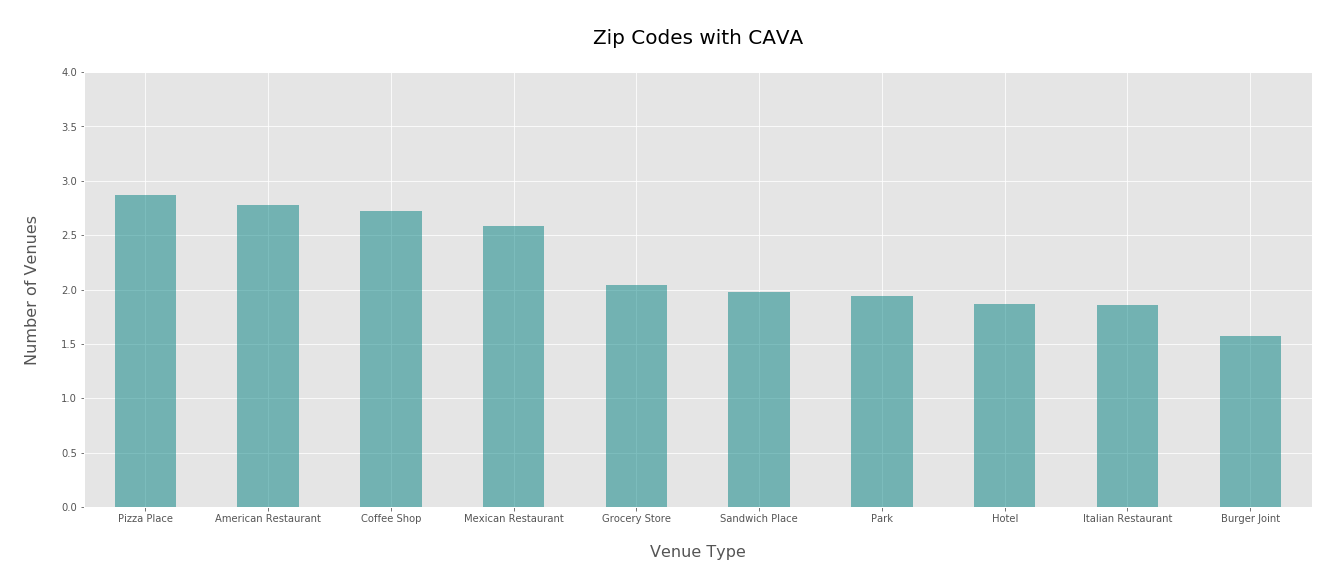

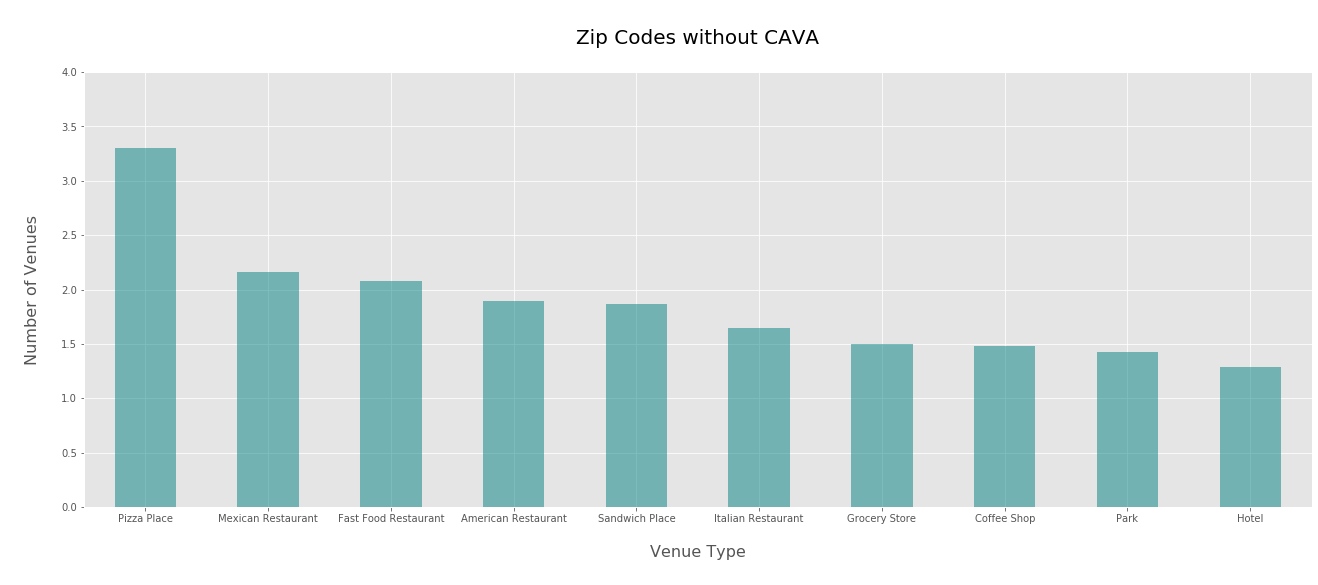

In [136]:
##
explored_grouped_cavs.plot(kind = 'bar',
                           figsize = (22,8),
                           align = 'center',
                           color = 'teal',
                           alpha = 0.5,
                           legend = None
                          )

plt.xlabel('\nVenue Type\n', fontsize = 16) # add to x-label to the plot
plt.ylabel('\nNumber of Venues\n', fontsize = 16) # add y-label to the plot
plt.title('\nZip Codes with CAVA\n', fontsize = 20) # add title to the plot
plt.xticks(rotation = 0, fontsize = 10)
plt.ylim(0,4)

explored_grouped_nocavs.plot(kind = 'bar',
                             figsize = (22,8),
                             align = 'center',
                             color = 'teal',
                             alpha = 0.5,
                             legend = None
                            )

plt.xlabel('\nVenue Type\n', fontsize = 16) # add to x-label to the plot
plt.ylabel('\nNumber of Venues\n', fontsize = 16) # add y-label to the plot
plt.title('\nZip Codes without CAVA\n', fontsize = 20) # add title to the plot
plt.xticks(rotation = 0, fontsize = 10)
plt.ylim(0,4)

print()
plt.show()

#### 

# Drop infrequent variables and collinear variables from 'near_vens_onehot_grouped_df'

In [ ]:
#### Import needed libraries

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np

# Collinearity assessment library
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("\nLibraries imported.\n")

In [ ]:
#### Drop variables that have 10 instances or less

In [ ]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_coded_grouped_venue_df', dtype = {'Zip Code' : str}).drop('Unnamed: 0', axis = 1)

print('\nDataframe shape before drop: ', training_dataset.shape, sep = '')

## If variable occurs in less than 10% (44 times) of training zip codes, on average, drop from dataset
for col in training_dataset.iloc[:,3:].columns.tolist():
    if sum(training_dataset[col]) < 44:
        training_dataset.drop(col, axis = 1, inplace = True)

## Check dataframe prepped properly
print('Dataframe shape after drop: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()

In [ ]:
#### Drop collinear variables from dataset

In [ ]:
keep_going = 0
iters_completed = 0

while keep_going == 0:

    vif_df = pd.DataFrame()
    X = training_dataset.iloc[:,3:]
    vif_df["Variables"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    vif_drop_vars = vif_df[vif_df['VIF'] > 2.5].sort_values(by = 'VIF', ascending = False)['Variables'].tolist()
    if len(vif_drop_vars) > 0:
        drop_var = vif_drop_vars[0]
        training_dataset.drop(drop_var, axis = 1, inplace = True)
    else:
        keep_going = 1

    iters_completed += 1
    print('Iterations completed: {}'.format(iters_completed), end = '\r')
        
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()

In [ ]:
training_dataset.to_csv('/Users/mitchelllee/cava_training_df')
print('\nDataset saved.\n')

#### 

#### 

# Develop optimal logistic regression model

In [ ]:
##### Import needed libraries

In [ ]:
#### 
## Standard libraries
import pandas as pd
import numpy as np

#### 
## LogReg Model libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

####
## Libraries for avoiding certain warnings
import warnings

####
## Math library
import math

####
print('\nLibraries imported.\n')

In [ ]:
##### Change the setting as needed

In [ ]:
####
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

####
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOptions set as desired.\n')

In [ ]:
##### Prepare the data

In [ ]:
####
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_training_df').drop('Unnamed: 0', axis = 1)

####
## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.sort_values(by = "City").head()

In [ ]:
##### Optimize a logistic regression model using RFE

In [ ]:
####
## Fit the selector across range of n features

# Define X and y and preprocess
X = training_dataset.iloc[:,3:]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

# Define predictors in dataset
predictors = training_dataset.iloc[:,3:].columns

# Test using number of features between 1 and all of them
min_features = 1
max_features = 6  # 16 is the highest number of predictors possible before the selector picks a combination that are not all statistically significant

# Define prediction model
reg_mod = LogisticRegression(C = 0.01)

# Make list of scoring for each n number of predictors
logreg_scores_list = []

# Keep track of iteration through number of features tested
completed = 0
total = max_features

# For each number of features to test, find best feature set and score for that feature set
for n in range(min_features, max_features + 1):
    
    selector = RFE(reg_mod, n_features_to_select = n).fit(X, y)
    keep_vars = np.asarray(predictors)[selector.support_]
    
    X_sub = np.asarray(training_dataset[keep_vars])
    X_sub = preprocessing.StandardScaler().fit(X_sub).transform(X_sub)

    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    logreg_scores_list.append([n, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper, keep_vars])
    
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')

####
## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
logreg_scores_df = pd.DataFrame(logreg_scores_list, columns = ['# Predictors',
                                                               'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                               'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                               'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI',
                                                               'Predictors']
                            )
## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
logreg_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', '# Predictors'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# Get number of predictors for best model
logreg_final_n = logreg_scores_df['# Predictors'].values[0]

# Get cross-validated score for best model
logreg_final_score = logreg_scores_df['Score'].values[0]
logreg_final_score_lower_CI = logreg_scores_df['Score Lower 95% CI'].values[0]
logreg_final_score_upper_CI = logreg_scores_df['Score Upper 95% CI'].values[0]

# Get cross-validated ppv for best model
logreg_final_ppv = logreg_scores_df['PPV'].values[0]
logreg_final_ppv_lower_CI = logreg_scores_df['PPV Lower 95% CI'].values[0]
logreg_final_ppv_upper_CI = logreg_scores_df['PPV Upper 95% CI'].values[0]

# Get cross-validated sensitivity for best model
logreg_final_sense = logreg_scores_df['Sensitivity'].values[0]
logreg_final_sense_lower_CI  = logreg_scores_df['Sensitivity Lower 95% CI'].values[0]
logreg_final_sense_upper_CI = logreg_scores_df['Sensitivity Upper 95% CI'].values[0]

# Get predictors used in optimal model
logreg_final_kept_vars = logreg_scores_df['Predictors'].values[0]

####
## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nBest # of predictors:                {}'.format(logreg_final_n))
print()

print('Final cross-validated score:         {}'.format(logreg_final_score))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(logreg_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(logreg_final_sense))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_sense_upper_CI))
print()

print('Best predictors:')
[print(' -', pred) for pred in logreg_final_kept_vars]
print()

####
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

fitted_mod = sm.Logit(y, X).fit()

print(fitted_mod.summary2())

####
## Show dataframe
logreg_scores_df.head(10)

#### 

# Develop optimal SVC model

In [ ]:
##### Import needed packages/libraries

In [ ]:
####
## Standard libraries
import pandas as pd
import numpy as np

####
## Import needed libraries
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

####
import warnings

####
import math

print('\nLibraries imported.\n')

In [ ]:
##### Change settings as need

In [ ]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

####
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOptions set as desired.\n')

In [ ]:
##### Prepare the data

In [ ]:
####
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_training_df').drop('Unnamed: 0', axis = 1)

####
## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.sort_values(by = "City").head()

In [ ]:
##### Develop the optimal model

In [ ]:
####
## Fit the selector across range of n features

# Define X and y and preprocess
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

# Define predictors in dataset
predictors = training_dataset.loc[:,logreg_final_kept_vars].columns

# Test using number of features between 1 and all of them
min_features = 1
max_features = len(predictors)  # the model performs poorly after 100 variables

# Define prediction model
svc_mod = SVC(kernel = 'linear')

# Make list of scoring for each n number of predictors
svc_scores_list = []

# Keep track of iteration through number of features tested
completed = 0
total = max_features

# For each number of features to test, find best feature set and score for that feature set
for n in range(min_features, max_features + 1):
    selector = RFE(svc_mod, n_features_to_select = n).fit(X, y)
    keep_vars = np.asarray(predictors[selector.support_])
    
    X_sub = training_dataset[keep_vars]
    X_sub = preprocessing.StandardScaler().fit(X_sub).transform(X_sub)
    
    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    svc_scores_list.append([n, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper, keep_vars])
    
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')

####
## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
svc_scores_df = pd.DataFrame(svc_scores_list, columns = ['# Predictors',
                                                         'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                         'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                         'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI',
                                                         'Predictors']
                            )
## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
svc_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', '# Predictors'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# Get number of predictors for best model
svc_final_n = svc_scores_df['# Predictors'].values[0]

# Get cross-validated score for best model
svc_final_score = svc_scores_df['Score'].values[0]
svc_final_score_lower_CI = svc_scores_df['Score Lower 95% CI'].values[0]
svc_final_score_upper_CI = svc_scores_df['Score Upper 95% CI'].values[0]

# Get cross-validated ppv for best model
svc_final_ppv = svc_scores_df['PPV'].values[0]
svc_final_ppv_lower_CI = svc_scores_df['PPV Lower 95% CI'].values[0]
svc_final_ppv_upper_CI = svc_scores_df['PPV Upper 95% CI'].values[0]

# Get cross-validated sensitivity for best model
svc_final_sense = svc_scores_df['Sensitivity'].values[0]
svc_final_sense_lower_CI  = svc_scores_df['Sensitivity Lower 95% CI'].values[0]
svc_final_sense_upper_CI = svc_scores_df['Sensitivity Upper 95% CI'].values[0]

# Get predictors used in optimal model
svc_final_kept_vars = svc_scores_df['Predictors'].values[0]

####
## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nBest # of predictors:                {}'.format(svc_final_n))
print()

print('Final cross-validated score:         {}'.format(svc_final_score))
print('Corresponding lower 95% CI:          {}'.format(svc_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(svc_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(svc_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(svc_final_sense))
print('Corresponding lower 95% CI:          {}'.format(svc_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_sense_upper_CI))
print()

print('Best predictors:')
[print(' -', pred) for pred in svc_final_kept_vars]
print()

#####
## Show dataframe
svc_scores_df.head(10)

#### 

# Develop optimal KNN model

In [ ]:
#### Import needed libraries

In [ ]:
####
## Standard libraries
import pandas as pd
import numpy as np

##
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

##
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

##
import warnings

##
import math

##
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

print('\nLibraries imported.\n')

In [ ]:
##### Change settings to avoid warning messages and improve output formats

In [ ]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

####
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOptions set as desired.\n')

In [ ]:
##### Load and prepare the data

In [ ]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/cava_training_df').drop('Unnamed: 0', axis = 1)

## Drop any variable that does not occur for any CAVA location (I think that makes more sense)
grouped_training_df = training_dataset.groupby(by = 'Has CAVA?').sum().drop(0)

for col in grouped_training_df.columns.tolist():
    if grouped_training_df[col].values[0] == 0:
        training_dataset.drop(col, axis = 1, inplace = True)

## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()

In [ ]:
#### Train and score the model across a different ks

In [ ]:
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

knn_scores_list = []

completed = 0
total = len(training_dataset.loc[:,logreg_final_kept_vars].columns)

for k in range(1, total):
    
    knn = KNeighborsClassifier(k)
    
    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(knn, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(knn, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(knn, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    knn_scores_list.append([k, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper])
    
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')

####
## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
knn_scores_df = pd.DataFrame(knn_scores_list, columns = ['K',
                                                         'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                         'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                         'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI'])

## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
knn_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', 'K'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# Get number of predictors for best model
knn_final_k = knn_scores_df['K'].values[0]

# Get cross-validated score for best model
knn_final_score = knn_scores_df['Score'].values[0]
knn_final_score_lower_CI = knn_scores_df['Score Lower 95% CI'].values[0]
knn_final_score_upper_CI = knn_scores_df['Score Upper 95% CI'].values[0]

# Get cross-validated ppv for best model
knn_final_ppv = knn_scores_df['PPV'].values[0]
knn_final_ppv_lower_CI = knn_scores_df['PPV Lower 95% CI'].values[0]
knn_final_ppv_upper_CI = knn_scores_df['PPV Upper 95% CI'].values[0]

# Get cross-validated sensitivity for best model
knn_final_sense = knn_scores_df['Sensitivity'].values[0]
knn_final_sense_lower_CI  = knn_scores_df['Sensitivity Lower 95% CI'].values[0]
knn_final_sense_upper_CI = knn_scores_df['Sensitivity Upper 95% CI'].values[0]

####
## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nFinal K:                             {}'.format(knn_final_k))
print()

print('Final cross-validated score:         {}'.format(knn_final_score))
print('Corresponding lower 95% CI:          {}'.format(knn_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(knn_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(knn_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(knn_final_sense))
print('Corresponding lower 95% CI:          {}'.format(knn_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_sense_upper_CI))
print()

#####
## Show dataframe
knn_scores_df.head(10)

#### 

# Report Model Scores

In [ ]:
final_score_report_df = pd.DataFrame([
    
    ['Logistic Regression', logreg_final_n,
     logreg_final_score, logreg_final_score_lower_CI, logreg_final_score_upper_CI,
     logreg_final_ppv, logreg_final_ppv_lower_CI, logreg_final_ppv_upper_CI,
     logreg_final_sense, logreg_final_sense_lower_CI, logreg_final_sense_upper_CI,
     logreg_final_kept_vars
    ],
    
    ['SVC', svc_final_n,
     svc_final_score, svc_final_score_lower_CI,
     svc_final_score_upper_CI,
     svc_final_ppv, svc_final_ppv_lower_CI, svc_final_ppv_upper_CI,
     svc_final_sense, svc_final_sense_lower_CI, svc_final_sense_upper_CI,
     svc_final_kept_vars
    ],
     
    ['KNN', knn_final_k,
     knn_final_score, knn_final_score_lower_CI, knn_final_score_upper_CI,
     knn_final_ppv, knn_final_ppv_lower_CI, knn_final_ppv_upper_CI,
     knn_final_sense, knn_final_sense_lower_CI, knn_final_sense_upper_CI,
     'NA'
    ]],
    
    columns = ['Model', 
               '# Predictors/Neighbors',
               'Final Score', 'Score Lower CI', 'Score Upper CI',
               'Final PPV', 'PPV Lower CI', 'PPV Upper CI',
               'Final Sensitivity', 'Sensitivity Lower CI', 'Sensitivity Upper CI',
               'Final Predictors'
              ]
)
     
     
final_score_report_df

#### ###
Based on the results above, I will use the SVC model with the variables kept for that model after optimization to predict the viability of new postal codes
as CAVA locations. I will, in particular, test the most populous zip codes in the most populous states that don't have a CAVA.
#### ###

#### 

# Make dataframe with venue data for most populous zip codes in states w/o CAVAs

In [ ]:
#### Import needed libraries

In [ ]:
#standard need libraries
import pandas as pd
import numpy as np

print('Libraries imported.')

In [ ]:
#### Load model training location info dataset

In [ ]:
## Read dataframe in from personal computer
training_loc_info_df = pd.read_csv('/Users/mitchelllee/cava_combo_loc_info_df').drop('Unnamed: 0', axis = 1)

## Show dataframe shape
print('\nDataframe shape: ', training_loc_info_df.shape, '\n', sep = '')
training_loc_info_df.sort_values('City').head()

In [ ]:
#### Get list of states without CAVA by population

In [ ]:
states_dict = {
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'NC': 'North Carolina',
    'NJ': 'New Jersey',
    'NY': 'New York',
    'PA': 'Pennsylvania',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'VA': 'Virginia'
}

## Get list of states with CAVA
cav_cities = set(training_loc_info_df['City'])
cav_states_abbvs = []
cav_states = []

for city in cav_cities:
    if states_dict[city.split(', ')[-1]] not in cav_states:
        cav_states.append(states_dict[city.split(', ')[-1]])

print('\nStates with CAVA: \n')
[print(state) for state in cav_states]

print('\n')

## Scrape list of states in order by population
states_df = pd.read_html('https://www.infoplease.com/us/states/state-population-by-rank')[0].iloc[:,[1,2]]
states_df.columns = ['State', 'Population']

for i, row in states_df.iterrows():
    if row['State'] in cav_states:
        states_df.drop(i, inplace = True)

# reset index and drop rows corresponding to DC (#36) and meta info (#39) as these rows are not needed
nocav_states_df = states_df.reset_index().drop('index', axis = 1).drop([36,39])
# make state names lowercase and remove spaces for website urls
nocav_states_df['State'] = nocav_states_df['State'].str.lower()

print('States without CAVA: ', nocav_states_df.shape, sep = '')
print('Dataframe shape: ', nocav_states_df.shape, '\n', sep = '')
nocav_states_df

In [ ]:
#### Make dataframe of zip codes to predict as CAVA locations 

In [ ]:
## Create dictionary to convert state names to abbreviations 

# only need first table in website and not 'Abbreviation' column of that table
state_names_abbvs_df = pd.read_html('https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes')[0]

# initialize a dictionary
state_names_abbvs_dict = {}
# define key, value pair for each state in dictionary
# make state name all lowercase and remove spaces for later use in urls (which require all lowercase and no spaces)
for i, row in state_names_abbvs_df.iterrows():
    state_names_abbvs_dict[row['State/District'].lower()] = row['Postal Code']

for item in list(state_names_abbvs_dict.items())[0:10]:
    print(item)

In [ ]:
## Get 20 most-populated zip codes in all states without CAVAs

# initialize empty dataset
pred_zip_loc_df = pd.DataFrame()

completed = 0 # used to keep track of progress through below 'for' loop
total = len(nocav_states_df) # used to keep track of progress through below 'for' loop

for state in nocav_states_df['State']:
    
    # get 10 biggest zip codes by population in the state from a website
    state_name_v1 = ''.join(state.split(' ')) #remove space from state name for url
    postals = pd.read_html('https://www.{}-demographics.com/zip_codes_by_population'.format(state_name_v1))[0][['Zip Code']].head(10)
    # make zip code 'string' type
    postals['Zip Code'] = postals['Zip Code'].astype(str)
    
    # get cities corresponding to all zip codes in the state
    state_name_v2 = '-'.join(state.split(' ')) # replace space with '-' in state name for url
    postal_cits = pd.read_html('https://www.zipdatamaps.com/list-of-zip-codes-in-{}.php'.format(state_name_v2))[0][['Zip Code', 'Zip Code Name']]
    # update city names to include state abbreviation using 'state_names_abbvs_dict' created above
    postal_cits['Zip Code Name'] = postal_cits['Zip Code Name'] + ', {}'.format(state_names_abbvs_dict[state])
    # make city names strings
    postal_cits['Zip Code'] = postal_cits['Zip Code'].astype(str)

    # use merge method to add corresponding city names to biggest zip codes in state ID'ed by line 14
    postals = postals.merge(postal_cits, on = 'Zip Code', how = 'inner')
    
    # add identified zip codes for current state to dataframe of all zip codes to predict as CAVA locations
    pred_zip_loc_df = pred_zip_loc_df.append(postals)

    # update and print progress reporter
    completed += 1
    print('Percent completed: {}%'.format(round(completed/total*100, 2)), end = '\r')
    
print()
print('\nDataframe shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.head()

In [ ]:
#### Add variables for prediction and coordinates

In [ ]:
pred_zip_loc_df['Latitude'] = ['-'] * len(pred_zip_loc_df)
pred_zip_loc_df['Longitude'] = ['-'] * len(pred_zip_loc_df)
pred_zip_loc_df['Prediction'] = ['-'] * len(pred_zip_loc_df)

pred_zip_loc_df = pred_zip_loc_df[['Prediction', 'Zip Code', 'Zip Code Name', 'Latitude', 'Longitude']]

pred_zip_loc_df.columns = ['Prediction', 'Zip Code', 'City', 'Latitude', 'Longitude']

print('\nDataframe shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.head()

In [ ]:
#### Get coordinate date for each row

In [ ]:
## Import needed libraries
from opencage.geocoder import OpenCageGeocode

## Define geocoding credentials
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

## Get coordinate data
total_items = len(pred_zip_loc_df)
completed_items = 0

for i, row in pred_zip_loc_df.iterrows():
    
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])
    
    location = zip_geocoder.geocode(query = input_address)
    row['Latitude'] = location[0]['geometry']['lat']
    row['Longitude'] = location[0]['geometry']['lng']
    
    completed_items += 1
    print('Percent complete: {}%'.format(round(completed_items/total_items*100, 3)), end = '\r')

print('\nDataframe Shape: ', pred_zip_loc_df.shape, sep = '')
pred_zip_loc_df.sort_values(by = 'City').head(10)

In [ ]:
#### Get venue data for coordinates using explore endpoint

In [ ]:
### ### ###
def getNearbyVenuesExplore(desigs, cities, postals, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    
    total = len(desigs)
    completed = 0
    
    for desig, city, postal, lat, lng in zip(desigs, cities, postals, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            results = []
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([desig,
                                    city,
                                    postal,
                                    lat,
                                    lng,
                                    v['venue']['name'],
                                    v['venue']['categories'][0]['name']])
            except KeyError:
                pass
        
        #show progress as percentage of 'result' output processed
        completed += 1
        print('Percent completed: {}%'.format(round(completed/total*100, 2)), end = '\r')
        

    #make 'venues_list' into a dataframe        
    nearby_vens = pd.DataFrame(venues_list)
    nearby_vens.columns = ['Has CAVA?',
                           'City',
                           'Zip Code',
                           'Latitude',
                           'Longitude',
                           'Venue',
                           'Venue Category']
    
    return(nearby_vens)

### ### ###

In [ ]:
##### Get venue data for coordinates using 'explore' endpoint

In [ ]:
## Import library
import requests

## Define FourSquare credentials
CLIENT_ID = 'C5TVLNNOZ3QX14URLNVGVXAKYHOT421V0KR21MSGVJY1O2CR' # my Foursquare ID
CLIENT_SECRET = 'BCTZ4WTEUPUZWKQO0RBRZQZUJ3QDSXV1Y2BKIW5VGUP32M2H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Get venues
pred_near_vens_df = getNearbyVenuesExplore(pred_zip_loc_df['Prediction'],
                                                pred_zip_loc_df['City'],
                                                pred_zip_loc_df['Zip Code'],
                                                pred_zip_loc_df['Latitude'],
                                                pred_zip_loc_df['Longitude'],
                                                3200,
                                                100
                                               )


print('\r                            ')
print('Processing completed.')
print('\nDataframe shape: ', pred_near_vens_df.shape, '\n', sep = '')   
pred_near_vens_df.head(10)

In [ ]:
#### Onehot coding of venues

In [ ]:
pred_near_vens_onehot_df = pd.get_dummies(pred_near_vens_df[['Venue Category']], prefix = "", prefix_sep="")

pred_near_vens_onehot_df['Zip Code'] = pred_near_vens_df['Zip Code']

try:
    pred_near_vens_onehot_df.drop('City', axis = 1, inplace = True)
except KeyError:
    pass

print('\nDataframe shape: ', pred_near_vens_onehot_df.shape, '\n', sep = '')   
pred_near_vens_onehot_df.head(10)

In [ ]:
#### Group venue data by zip code

In [ ]:
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_df.groupby(by = 'Zip Code').sum()

pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_grouped_df.merge(pred_zip_loc_df, on = 'Zip Code', how = 'inner')
pred_near_vens_onehot_grouped_df.head()

ord_cols = list(set(pred_near_vens_onehot_grouped_df.columns.tolist()) - set(['Zip Code', 'City', 'Prediction']))
ord_cols = ['Prediction','Zip Code', 'City'] + ord_cols

pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_grouped_df[ord_cols] 

print('\nDataframe shape: ', pred_near_vens_onehot_grouped_df.shape, '\n', sep = '')   
pred_near_vens_onehot_grouped_df.head(10)

In [ ]:
#### Save dataframe to personal computer

In [ ]:
pred_near_vens_onehot_grouped_df.to_csv('/Users/mitchelllee/cava_pred_df')
print('\nDataframe saved.')

#### 

# Predict CAVA success in new zip Codes with optimum SVC model

In [ ]:
## Load needed libraries

In [ ]:
#standard libraries
import pandas as pd
import numpy as np

## Import needed libraries
from sklearn import preprocessing

from sklearn.svm import SVC
print('\nLibraries impored.\n')

In [ ]:
#### Load dataset to predict

In [ ]:
prediction_df = pd.read_csv('/Users/mitchelllee/cava_pred_df').drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')   
prediction_df.head()

In [ ]:
#### Test if new zip venue dataframe contains every variable used in optimum SVC model
#### If present, make prediction_df have only those variables

In [ ]:
#take list of predictors returned from svc predictor optimization segment of this doc
prediction_df = prediction_df[['Prediction','Zip Code', 'City'] + svc_final_kept_vars.tolist()]

print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')   
prediction_df.head()

In [ ]:
##### Train SVC model as optimized earlier

In [ ]:
## load training dataset
training_df = pd.read_csv('cava_training_df').drop('Unnamed: 0', axis = 1)

print('\nDataframe shape: ', training_df.shape, '\n', sep = '')   
training_df.head()

In [ ]:
## train model as optimized
X_train = training_df.loc[:,svc_final_kept_vars]
y_train = training_df['Has CAVA?']
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)

pred_mod = SVC(kernel = 'linear')
pred_mod = pred_mod.fit(X_train, y_train)

print('\nModel fitted.\n')

##
# calculate cross-validated score for current set of predictors
cvs_score = cross_val_score(pred_mod, X = X_train, y = y_train, cv = 10)
score = round(cvs_score.mean(), 2)
score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
# calculate cross-validated ppv (precision)
cvs_prec = cross_val_score(pred_mod, X = X_train, y = y_train, cv = 10, scoring = 'precision')
prec = round(cvs_prec.mean(), 2)
prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

# calculate cross-validated sensitivity (recall)   
cvs_sense = cross_val_score(pred_mod, X = X_train, y = y_train, cv = 10, scoring = 'recall')
sense = round(cvs_sense.mean(), 2)
sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

###
print('\rPercent completed: 100%                                                     ')

print('\nBest K:                              {}'.format(svc_final_n))
print()

print('Final cross-validated score:         {}'.format(score))
print('Corresponding lower 95% CI:          {}'.format(score_95CI_lower))
print('Corresponding upper 95% CI:          {}'.format(score_95CI_upper))
print()

print('Final cross-validated PPV:           {}'.format(prec))
print('Corresponding lower 95% CI:          {}'.format(prec_95CI_lower))
print('Corresponding upper 95% CI:          {}'.format(prec_95CI_upper))
print()

print('Final cross-validated Sensitivity:   {}'.format(sense))
print('Corresponding lower 95% CI:          {}'.format(sense_95CI_lower))
print('Corresponding upper 95% CI:          {}'.format(sense_95CI_upper))
print()

In [ ]:
##### Use prediction model to predict if new zip are good CAVA locations

In [ ]:
prediction_df['Prediction'] = pred_mod.predict(prediction_df.iloc[:, 3:])

print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')
prediction_df.sort_values(by = 'Prediction', ascending = False).head(20)